In [3]:
import numpy as np 
import pandas as pd
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!ls '/content/drive/My Drive/dataset/'

dataset.xlsx  glove.6B.50d.txt	glove.6B.50d.txt.zip


In [6]:
df = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')
df.head()

,URL,Text,Sentiment
0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS
1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS
2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS
3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS
4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS


### Removing urls from the reviews:

In [9]:
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()

In [10]:
df['text'] = df['Text'].apply(clean_str)

In [12]:
df.Sentiment.value_counts()

NEG    1000
POS    999 
Name: Sentiment, dtype: int64

In [13]:
df_0 = df[df['Sentiment'] == 'POS'].sample(frac=1)
df_1 = df[df['Sentiment'] == 'NEG'].sample(frac=1)

# we want a balanced set for training against - there are 7072 `0` examples
sample_size = 999

data = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)

In [14]:
data.Sentiment.value_counts()

NEG    999
POS    999
Name: Sentiment, dtype: int64

In [15]:
data['l'] = data['text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 258.474974974975
max length of sentence: 1843
std dev length of sentence: 180.6102134381438


## Tokenization Of Sentences

In [16]:
sequence_length = 260 # On an average each review has around 260 words

In [17]:
max_features = 25000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(df['text'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(df['text'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(df['Sentiment']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("test set size " + str(len(X_test)))

test set size 600




```
# This is formatted as code
```

### Transformation and Vectorization

In [23]:
embeddings_index = {}
f = open('/content/drive/My Drive/dataset/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [24]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34724 unique tokens.


In [25]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)
non_exist_word_count=0
embedding_dim = 50 #Can try 50/100/200

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in our tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        non_exist_word_count=non_exist_word_count+1     
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
print('Count for non exist words in dict :',non_exist_word_count)

25001
Count for non exist words in dict : 5489


### CNN

In [30]:
from tensorflow.python.keras import regularizers

inputs_3 = Input(shape=(sequence_length,), dtype='int32')
num_filters = 50
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs_3)
reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)
conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(1e-3))(reshape_3)
maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)

flatten_3 = Flatten()(maxpool_0_3)

# do dropout and predict
dropout_3 = Dropout(0.5)(flatten_3)
output_3 = Dense(units=2, activation='softmax')(dropout_3)

In [31]:
model_3 = Model(inputs=inputs_3, outputs=output_3)
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 260)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 260, 50)           1250050   
_________________________________________________________________
reshape_1 (Reshape)          (None, 260, 50, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 258, 1, 50)        7550      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0   

In [32]:
batch_size = 32
history_3 = model_3.fit(X_train, y_train, epochs=8, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/8
40/40 [==============================] - 2s 40ms/step - loss: 0.5984 - accuracy: 0.6607 - val_loss: 0.3130 - val_accuracy: 0.9286
Epoch 2/8
40/40 [==============================] - 1s 36ms/step - loss: 0.3090 - accuracy: 0.9148 - val_loss: 0.2798 - val_accuracy: 0.9286
Epoch 3/8
40/40 [==============================] - 1s 36ms/step - loss: 0.3004 - accuracy: 0.9050 - val_loss: 0.2654 - val_accuracy: 0.9286
Epoch 4/8
40/40 [==============================] - 1s 35ms/step - loss: 0.2641 - accuracy: 0.9146 - val_loss: 0.2587 - val_accuracy: 0.9286
Epoch 5/8
40/40 [==============================] - 1s 35ms/step - loss: 0.2417 - accuracy: 0.9254 - val_loss: 0.2551 - val_accuracy: 0.9286
Epoch 6/8
40/40 [==============================] - 1s 35ms/step - loss: 0.2210 - accuracy: 0.9346 - val_loss: 0.2518 - val_accuracy: 0.9214
Epoch 7/8
40/40 [==============================] - 1s 35ms/step - loss: 0.1965 - accuracy: 0.9411 - val_loss: 0.2496 - val_accuracy: 0.9214
Epoch 8/8
40/40 [===

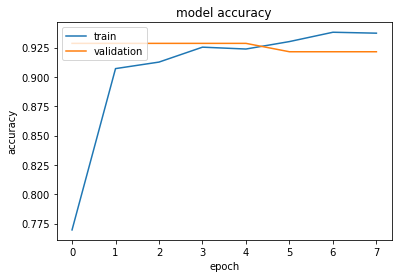

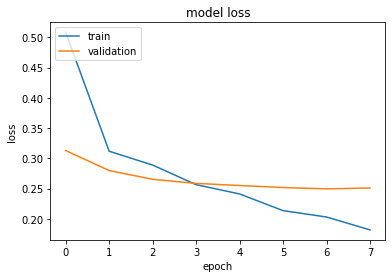

In [33]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
## Helper Function

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import pickle

def generate_report(pred_list, custom_model, model_name,y_test):
  print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_list)}')
  print(f'\nClassification Report:\n{classification_report(y_test,pred_list)}')
  acc = accuracy_score(y_test, pred_list) * 100
  print(f'Accuracy: {acc}%')
  prec = precision_score(y_test, pred_list, average='macro') * 100
  print(f'Precision: {prec}%')
  rec = recall_score(y_test, pred_list, average='macro') * 100
  print(f'Recall: {rec}%')
  # pickle.dump(custom_model, open(model_name + '.sav', 'wb'))
  print(model_name + ' trained')
  return acc, prec, rec

In [35]:
y_hat_3 = model_3.predict(X_test)

In [41]:
cnn_metrics = [None, None, None]
cnn_metrics[0], cnn_metrics[1], cnn_metrics[2] = generate_report(y_hat_3.argmax(axis=1), model_3, 'CNN_model',y_test.argmax(axis=1))

Confusion Matrix:
[[297   8]
 [ 33 262]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       305
           1       0.97      0.89      0.93       295

    accuracy                           0.93       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

Accuracy: 93.16666666666666%
Precision: 93.5185185185185%
Recall: 93.09530425118089%
CNN_model trained


### LSTM

In [42]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [43]:
model = Sequential()

model.add(Embedding(num_words,embedding_dim,
                              embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True))
model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 260, 50)           1250050   
_________________________________________________________________
lstm (LSTM)                  (None, 260, 256)          314368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 1,774,640
Trainable params: 1,774,640
Non-trainable params: 0
______________________________________________

In [44]:
history_5 = model.fit(X_train, y_train, epochs=7, batch_size=256, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/7
5/5 [==============================] - 47s 8s/step - loss: 0.7500 - accuracy: 0.5221 - val_loss: 0.6797 - val_accuracy: 0.5214
Epoch 2/7
5/5 [==============================] - 39s 8s/step - loss: 0.6791 - accuracy: 0.5781 - val_loss: 0.5692 - val_accuracy: 0.7143
Epoch 3/7
5/5 [==============================] - 39s 8s/step - loss: 0.7337 - accuracy: 0.7114 - val_loss: 0.7593 - val_accuracy: 0.4857
Epoch 4/7
5/5 [==============================] - 39s 8s/step - loss: 0.6907 - accuracy: 0.5408 - val_loss: 0.6711 - val_accuracy: 0.5500
Epoch 5/7
5/5 [==============================] - 39s 8s/step - loss: 0.6785 - accuracy: 0.5361 - val_loss: 0.6831 - val_accuracy: 0.4857
Epoch 6/7
5/5 [==============================] - 38s 8s/step - loss: 0.6772 - accuracy: 0.5398 - val_loss: 0.6746 - val_accuracy: 0.5357
Epoch 7/7
5/5 [==============================] - 39s 8s/step - loss: 0.6807 - accuracy: 0.5033 - val_loss: 0.6723 - val_accuracy: 0.6429


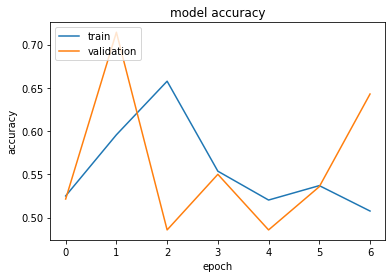

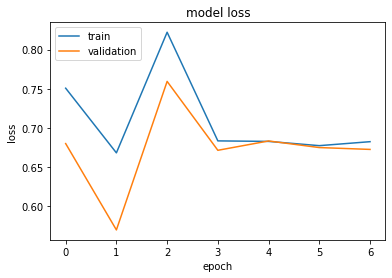

In [45]:
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
y_hat_5 = model.predict(X_test)

In [49]:
lstm_metrics = [None, None, None]
lstm_metrics[0], lstm_metrics[1], lstm_metrics[2] = generate_report(y_hat_5.argmax(axis=1), model, 'LSTM_model',y_test.argmax(axis=1))

Confusion Matrix:
[[164 141]
 [ 75 220]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.54      0.60       305
           1       0.61      0.75      0.67       295

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.64       600
weighted avg       0.65      0.64      0.64       600

Accuracy: 64.0%
Precision: 64.78053755838616%
Recall: 64.17338149485968%
LSTM_model trained


### Decision Tree Classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [51]:
dt_clf = DecisionTreeClassifier()

# Train the Model
dt_clf.fit(X_train,y_train)   
dt_pred = dt_clf.predict(X_test)

In [52]:
dt_metrics = [None, None, None]
dt_metrics[0], dt_metrics[1], dt_metrics[2] = generate_report(dt_pred.argmax(axis=1), dt_clf, 'DecisionTree_model',y_test.argmax(axis=1))

Confusion Matrix:
[[213  92]
 [ 84 211]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       305
           1       0.70      0.72      0.71       295

    accuracy                           0.71       600
   macro avg       0.71      0.71      0.71       600
weighted avg       0.71      0.71      0.71       600

Accuracy: 70.66666666666667%
Precision: 70.67706770677067%
Recall: 70.68074465129203%
DecisionTree_model trained


### Bernoulli Naive Bayes:

In [53]:
from sklearn.naive_bayes import BernoulliNB
bnb_clf = BernoulliNB()
bnb_clf.fit(X_train,y_train.argmax(axis=1))
BNBpred=bnb_clf.predict(X_test)

In [54]:
bnb_metrics = [None, None, None]
bnb_metrics[0], bnb_metrics[1], bnb_metrics[2] = generate_report(BNBpred, bnb_clf, 'BernoulliNB_model',y_test.argmax(axis=1))

Confusion Matrix:
[[165 140]
 [154 141]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       305
           1       0.50      0.48      0.49       295

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.51      0.51      0.51       600

Accuracy: 51.0%
Precision: 50.9510369370475%
Recall: 50.947485412614625%
BernoulliNB_model trained


### Multinomial Naive Bayes:

In [55]:
from sklearn.naive_bayes import MultinomialNB

In [56]:
mnb_clf = MultinomialNB()

#train the model
mnb_clf.fit(X_train,y_train.argmax(axis=1))
MNBpred=mnb_clf.predict(X_test)

In [57]:
mnb_metrics = [None, None, None]
mnb_metrics[0], mnb_metrics[1], mnb_metrics[2] = generate_report(MNBpred, mnb_clf, 'MultinomialNB_model',y_test.argmax(axis=1))

Confusion Matrix:
[[145 160]
 [127 168]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50       305
           1       0.51      0.57      0.54       295

    accuracy                           0.52       600
   macro avg       0.52      0.52      0.52       600
weighted avg       0.52      0.52      0.52       600

Accuracy: 52.166666666666664%
Precision: 52.264167862266866%
Recall: 52.24506807446513%
MultinomialNB_model trained


### Maximum Entropy (Logistic Regression):

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
lr_clf = LogisticRegression(max_iter=300)

# Train the Model
lr_clf.fit(X_train,y_train.argmax(axis=1))   
LRpred = lr_clf.predict(X_test)

lr_metrics = [None, None, None]
lr_metrics[0], lr_metrics[1], lr_metrics[2] = generate_report(LRpred, lr_clf, 'LinearRegression_model',y_test.argmax(axis=1))

Confusion Matrix:
[[204 101]
 [106 189]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       305
           1       0.65      0.64      0.65       295

    accuracy                           0.66       600
   macro avg       0.65      0.65      0.65       600
weighted avg       0.65      0.66      0.65       600

Accuracy: 65.5%
Precision: 65.48943270300333%
Recall: 65.47652125590442%
LinearRegression_model trained


### Support Vector Machine:

In [60]:
from sklearn.svm import SVC
from sklearn import svm

In [61]:
SVMclassifier = svm.SVC()
SVMclassifier.fit(X_train,y_train.argmax(axis=1))
SVMpred = SVMclassifier.predict(X_test)

In [62]:
svm_metrics = [None, None, None]
svm_metrics[0], svm_metrics[1], svm_metrics[2] = generate_report(SVMpred, SVMclassifier, 'SVM_model',y_test.argmax(axis=1))

Confusion Matrix:
[[264  41]
 [ 76 219]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       305
           1       0.84      0.74      0.79       295

    accuracy                           0.81       600
   macro avg       0.81      0.80      0.80       600
weighted avg       0.81      0.81      0.80       600

Accuracy: 80.5%
Precision: 80.93891402714932%
Recall: 80.39733259238677%
SVM_model trained


## Results Comparisons plots and tables:

In [63]:
!pip3 install tabulate
from tabulate import tabulate
table = [['Model Name', 'Accuracy', 'Precision', 'Recall'], 
         ['Multinomial Naïve Bayes', mnb_metrics[0], mnb_metrics[1], mnb_metrics[2]], 
         ['Bernoulli Naïve Bayes', bnb_metrics[0], bnb_metrics[1], bnb_metrics[2]],
         ['Support Vector Machine', svm_metrics[0], svm_metrics[1], svm_metrics[2]],
         ['Maximum Entropy', lr_metrics[0], lr_metrics[1], lr_metrics[2]],
         ['Decision Tree', dt_metrics[0], dt_metrics[1], dt_metrics[2]],
         ['CNN', cnn_metrics[0], cnn_metrics[1], cnn_metrics[2]],
         ['LSTM', lstm_metrics[0], lstm_metrics[1], lstm_metrics[2]]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤════════════╤═════════════╤══════════╕
│ Model Name              │   Accuracy │   Precision │   Recall │
╞═════════════════════════╪════════════╪═════════════╪══════════╡
│ Multinomial Naïve Bayes │    52.1667 │     52.2642 │  52.2451 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Bernoulli Naïve Bayes   │    51      │     50.951  │  50.9475 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Support Vector Machine  │    80.5    │     80.9389 │  80.3973 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Maximum Entropy         │    65.5    │     65.4894 │  65.4765 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Decision Tree           │    70.6667 │     70.6771 │  70.6807 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ CNN                     │    93.1667 │     93.5185 │  93.0953 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ LSTM    

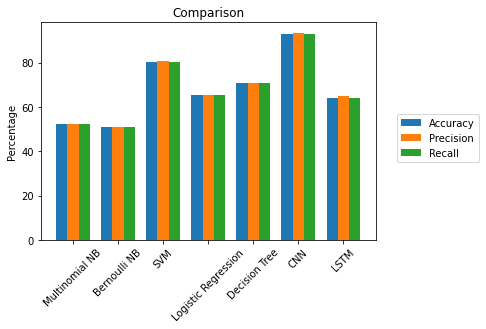

In [64]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 7
ind = np.arange(N) 
width = 0.25
  
acc = [mnb_metrics[0], bnb_metrics[0], svm_metrics[0], lr_metrics[0], dt_metrics[0], cnn_metrics[0], lstm_metrics[0]]
bar1 = plt.bar(ind, acc, width)
  
prec = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1], cnn_metrics[1], lstm_metrics[1]]
bar2 = plt.bar(ind+width, prec, width)
  
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2], cnn_metrics[2], lstm_metrics[2]]
bar3 = plt.bar(ind+width*2, recall, width)
  
# plt.xlabel("Dates")
plt.ylabel("Percentage")
plt.title("Comparison")
  
plt.xticks(ind+width,['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree', 'CNN', 'LSTM'])
plt.xticks(rotation = 45)
plt.legend( (bar1, bar2, bar3), ('Accuracy', 'Precision', 'Recall'), bbox_to_anchor = (1.05, 0.6))
plt.show()

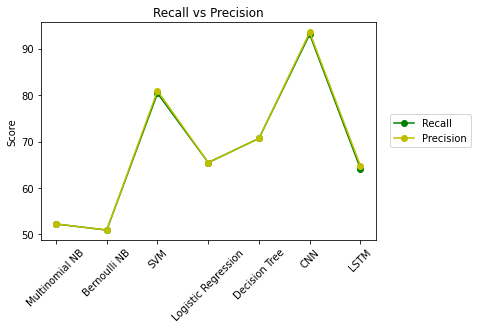

In [65]:
import matplotlib.pyplot as plt
models = ['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree', 'CNN', 'LSTM']
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2], cnn_metrics[2], lstm_metrics[2]]
precision = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1], cnn_metrics[1], lstm_metrics[1]]
line_chart1 = plt.plot(models, recall, 'o-g')
line_chart2 = plt.plot(models, precision, 'o-y')
plt.title('Recall vs Precision')
plt.ylabel('Score')
plt.xticks(rotation = 45)
plt.legend(['Recall', 'Precision'], bbox_to_anchor = (1.3, 0.6))
plt.show()